In [1]:
import os
import seaborn as sns

import torch
import torch.nn as nn

from models.dcgan import Generator as DcganGenerator, Discriminator as DcganDiscriminator
from models.biggan.BigGAN import Discriminator as BigGanDiscriminator, Generator as BigGanGenerator

from utils.utils import visualize, get_dataloader
from utils.train import train_dcgan, train_biggan

sns.set(font_scale=1.3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data

In [2]:
dataroot = 'images'
n_classes = len(os.listdir(dataroot))

dataloader = get_dataloader(dataroot, (128, 128), 32)

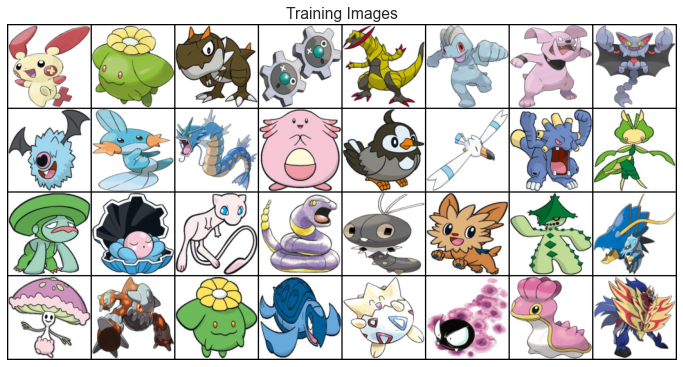

In [3]:
visualize(next(iter(dataloader))[0], 'Training Images')

# DCGAN

* Оригинальная статья: https://arxiv.org/pdf/1511.06434.pdf
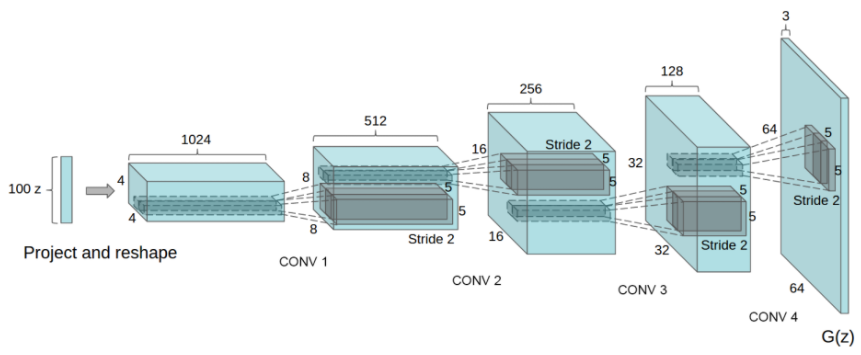

DCGAN использует сверточные и обратные сверточные слои в дискриминаторе и генераторе. 
* Дискриминатор состоит из чередующихся сверточных слоев, слоев нормализации и активаций LeakyReLU. Входными данными является изображение размером 3x64x64, а выходными &mdash; вероятность, что входные данные получены из реальных. 
* Генератор состоит из обратных сверточных слоев, слоев нормализации и активаций ReLU. Входные данные представляют собой скрытый вектор z, взятый из стандартного нормального распределения, а выходными данными является изображение RGB размером 3x64x64. Архитектура генератора представлена выше.

In [4]:
dataloader = get_dataloader(dataroot, (64, 64), 128)

epoch number: 250
time per epoch: 10.055s
discriminator loss: 0.797
generator loss: 0.696


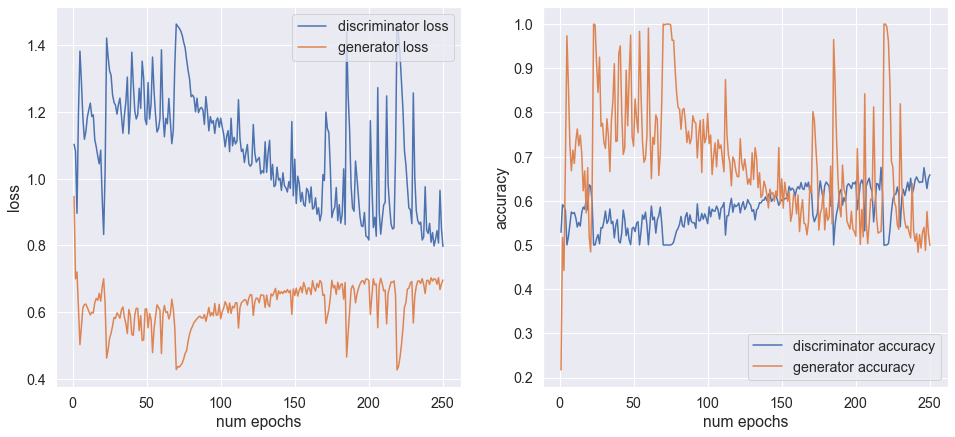

In [5]:
dcgan_discriminator = DcganDiscriminator(64).to(device)
dcgan_generator = DcganGenerator(100, 64).to(device)

optimizer_discriminator = torch.optim.Adam(dcgan_discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))
optimizer_generator = torch.optim.Adam(dcgan_generator.parameters(), lr=2e-4, betas=(0.5, 0.999))
criterion = nn.BCELoss()

dcgan_discriminator, dcgan_generator, history = train_dcgan(
    dcgan_discriminator, dcgan_generator, criterion,
    optimizer_discriminator, optimizer_generator,
    dataloader, 250
) 

In [6]:
torch.save(dcgan_generator.state_dict(), './saved_models/DCGAN/generator.pth')

# BigGAN fine-tuning

* Оригинальная статья: https://arxiv.org/pdf/1809.11096.pdf
* Реализация взята с https://github.com/ajbrock/BigGAN-PyTorch
* Веса для fine-tuning взяты [здесь](https://drive.google.com/file/d/1dmZrcVJUAWkPBGza_XgswSuT-UODXZcO/view)  
  
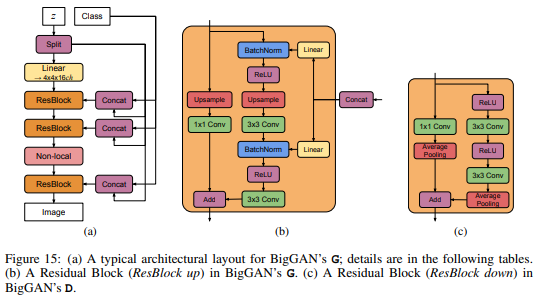
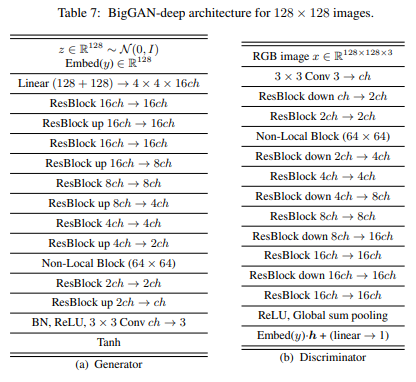

BigGAN продолжает идею DCGAN использования сверточных слоев, слоев нормализации и функции активации ReLU. Ко всему прочему добавляется использование модуля Self-Attention и Hinge-Loss. 
* BigGAN использует информацию и классе, преобразуя метку класса в вектор размерности 128, используя embedding слой.
* Для решения проблемы взрыва градиентов используется спектральная нормализация.
* Для борьбы с затуханием градиентов искользуется skip-connection.
* Во время создания картинок (в режиме eval) используется truncation trick, суть которого заключается в ограничении латентного пространства, что **повышает качество картинок, но ограничивает их вариативность**
* Увеличение параметров модели. Увеличив число каналов в каждом слое на 50%, качество модели улучшилось на 21%.
* Усреднение весов модели перед генерацией картинок.
  
Из репозитория взята только модель, чтобы самостоятельно контролировать ее процесс дообучения.

In [7]:
dataloader = get_dataloader(dataroot, (128, 128), 8)

In [8]:
embed = BigGanDiscriminator(n_classes=n_classes, D_ch=96).to(device).embed
shared = BigGanGenerator(n_classes=n_classes).to(device).shared

Adding attention layer in D at resolution 64
Param count for Ds initialized parameters: 87825697
Adding attention layer in G at resolution 64
Param count for Gs initialized parameters: 33537795


In [9]:
biggan_discriminator = BigGanDiscriminator(**torch.load('./fine_tuned_weights/state_dict.pth')['config']).to(device)
biggan_discriminator.load_state_dict(torch.load('./fine_tuned_weights/D.pth'))
biggan_discriminator.optim.load_state_dict(torch.load('./fine_tuned_weights/D_optim.pth'))
biggan_discriminator.embed = embed

biggan_generator = BigGanGenerator(**torch.load('./fine_tuned_weights/state_dict.pth')['config']).to(device)
biggan_generator.load_state_dict(torch.load('./fine_tuned_weights/G.pth'))
biggan_generator.optim.load_state_dict(torch.load('./fine_tuned_weights/G_optim.pth'))
biggan_generator.shared = shared

Adding attention layer in D at resolution 64
Param count for Ds initialized parameters: 87982369
Adding attention layer in G at resolution 64
Param count for Gs initialized parameters: 70433795


epoch number: 3
time per epoch: 185.893s
discriminator loss: 1.696
generator loss: 0.388


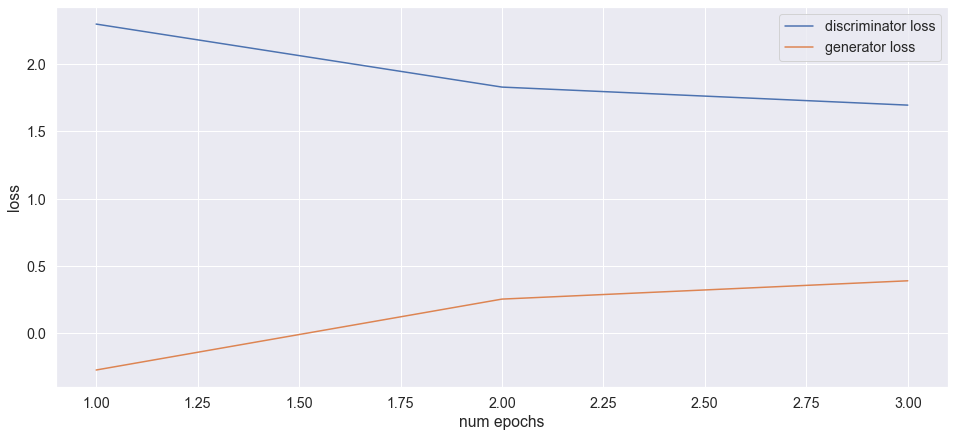

In [10]:
biggan_discriminator, biggan_generator, history = train_biggan(
    biggan_discriminator, biggan_generator, dataloader, 3, n_classes
)

In [11]:
torch.save(biggan_generator.state_dict(), './saved_models/BigGAN/generator.pth')

config = torch.load('./fine_tuned_weights/state_dict.pth')['config']
config['n_classes'] = n_classes
torch.save(config, './saved_models/BigGAN/config.pth')